In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")

print(device)

mps


In [3]:
torch.manual_seed(17)

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

train_augs = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        normalize,
    ]
)

test_augs = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        normalize,
    ]
)

In [4]:
pretrained_net = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)

In [5]:
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

In [39]:
finetuned_net = nn.Sequential(
    pretrained_net,
    nn.ReLU(),
    nn.Linear(1000, 2),
)

In [40]:
import time
import copy


def train_model(
    model, dataloaders, criterion, optimizer, num_epochs=25
):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs + 1):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    # Get model outputs and calculate loss

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "val":
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best val Acc: {:4f}".format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [41]:
import os

data_dir = "side"
batch_size = 32

model_ft = finetuned_net.to(device)
train_iter = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, "train"), transform=train_augs
    ),
    batch_size=batch_size,
    shuffle=True,
)
test_iter = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, "test"), transform=test_augs
    ),
    shuffle=True,
    batch_size=batch_size,
)
loss = nn.CrossEntropyLoss(reduction="none")

In [42]:
def train_fine_tuning(net, learning_rate, num_epochs=15):

    trainer = torch.optim.SGD([{"params": finetuned_net[2].parameters(), "lr": learning_rate*10}], lr=learning_rate) # your code here

    dataloaders_dict = {"train": train_iter, "val": test_iter}
    criterion = nn.CrossEntropyLoss()
    model_ft, hist = train_model(
        net, dataloaders_dict, criterion, trainer, num_epochs=num_epochs
    )
    return model_ft, hist


In [43]:
import numpy as np

In [44]:
model_ft, hist = train_fine_tuning(model_ft, learning_rate=5e-5)

Epoch 1/15
----------
train Loss: 0.6974 Acc: 0.5950
val Loss: 0.5555 Acc: 0.7560

Epoch 2/15
----------
train Loss: 0.5688 Acc: 0.7033
val Loss: 0.5063 Acc: 0.7500

Epoch 3/15
----------
train Loss: 0.5381 Acc: 0.7550
val Loss: 0.4706 Acc: 0.7738

Epoch 4/15
----------
train Loss: 0.5128 Acc: 0.7400
val Loss: 0.4434 Acc: 0.7857

Epoch 5/15
----------
train Loss: 0.4782 Acc: 0.7750
val Loss: 0.4199 Acc: 0.8155

Epoch 6/15
----------
train Loss: 0.4672 Acc: 0.7767
val Loss: 0.4040 Acc: 0.8155

Epoch 7/15
----------
train Loss: 0.4398 Acc: 0.7833
val Loss: 0.3833 Acc: 0.8393

Epoch 8/15
----------
train Loss: 0.4515 Acc: 0.8000
val Loss: 0.3656 Acc: 0.8512

Epoch 9/15
----------
train Loss: 0.4083 Acc: 0.8250
val Loss: 0.3555 Acc: 0.8631

Epoch 10/15
----------
train Loss: 0.4435 Acc: 0.8050
val Loss: 0.3484 Acc: 0.8631

Epoch 11/15
----------
train Loss: 0.4072 Acc: 0.8433
val Loss: 0.3338 Acc: 0.8631

Epoch 12/15
----------
train Loss: 0.4021 Acc: 0.8250
val Loss: 0.3294 Acc: 0.8690

E

In [45]:
def imshow(img, title=None):
    img = img.permute(1, 2, 0).numpy()
    means = np.array([0.485, 0.456, 0.406])
    stds = np.array([0.229, 0.224, 0.225])
    img = stds * img + means
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    if title is not None:
        plt.title(title)

    plt.pause(0.001)

In [58]:
import torch

def predykcja(zdjęcie, model, normalizacja):
  """
  Funkcja wykonująca predykcję na pojedynczym zdjęciu.

  Args:
    zdjęcie: Obraz typu PIL Image.
    model: Wytrenowany model sieciowy.
    normalizacja: Obiekt transformacji normalizującej dane.

  Returns:
    Klasa przewidywana dla danego zdjęcia.
  """

  # Konwersja obrazu na tensor PyTorch.
  zdjęcie_tensor = torch.from_numpy(np.array(zdjęcie)).float()
  # zdjęcie_tensor = zdjęcie_tensor.permute(2, 0, 1)  # Zmiana kolejności wymiarów (kanały, wysokość, szerokość).

  # Zastosowanie transformacji i normalizacji.
  zdjęcie_tensor = normalizacja(zdjęcie_tensor)

  # Dodanie wymiaru batch (wymagane przez niektóre modele).
  zdjęcie_tensor = zdjęcie_tensor.unsqueeze(0)

  # Wykonanie predykcji za pomocą modelu.
  z_pred = model(zdjęcie_tensor)

  # Zwrócenie przewidywanej klasy z największym prawdopodobieństwem.
  _, klasa_pred = torch.max(z_pred.data, 1)
  return klasa_pred.item()


In [59]:
import PIL

# Załadowanie wytrenowanego modelu
model = model_ft  # Załaduj swój wytrenowany model sieciowy

# Utworzenie obiektu normalizacji
normalizacja = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Załadowanie zdjęcia
zdjęcie = PIL.Image.open("side/train/right/131aedfhs6pnf1fvtvp49jxvwajp7b1s22_25.png")

# Wykonanie predykcji
klasa_pred = predykcja(zdjęcie, model, normalizacja)

# Wyświetlenie wyniku
print(f"Przewidywana klasa: {klasa_pred}")


ValueError: Expected tensor to be a tensor image of size (..., C, H, W). Got tensor.size() = torch.Size([512, 512])

In [46]:
import matplotlib.pyplot as plt
plt.ion()


def visualize_model(model, num_images=6):
    class_names = ["left", "right"]
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_iter):
            print(len(inputs))
            print(inputs)
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            print("output")
            print(outputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')

                imshow(inputs.data[j].cpu())

                if images_so_far == num_images:
                    return


32
tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044

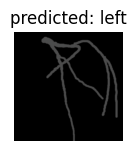

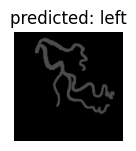

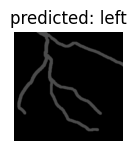

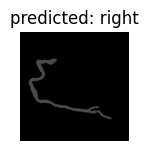

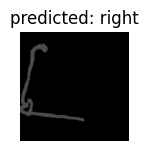

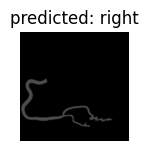

In [47]:
visualize_model(model_ft)